# BUSCO Results Analysis

Exploratory analysis of `BUSCO.tsv` — completeness metrics for eukaryotic genome annotations scored against `eukaryota_odb12`.

## BUSCO Color Convention

Standard BUSCO category colors (from `gitlab.com/ezlab/busco`):

| Category | Hex Code | Color |
|----------|----------|-------|
| Complete (C) and single-copy (S) | `#56B4E9` | Light Blue |
| Complete (C) and duplicated (D) | `#3492C7` | Dark Blue |
| Fragmented (F) | `#F0E442` | Yellow |
| Missing (M) | `#F04442` | Red |

Use these colors for consistency with official BUSCO visualizations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties

In [2]:
# BUSCO color scheme
BUSCO_COLORS = ["#56B4E9", "#56B4E9", "#3492C7", "#F0E442", "#F04442"]
BUSCO_CATEGORIES = ["complete","single", "duplicated", "fragmented", "missing"]

BUSCO_COLOR_MAP = {
       "complete": "#56B4E9",
       "single": "#56B4E9",
       "duplicated": "#3492C7",
       "fragmented": "#F0E442",
       "missing": "#F04442"
   }


TIER_PALETTE = ["#E0E0E0", "#B0B0B0", "#808080", "#505050", "#202020"]
TIER_ORDER = ["High (≥98%)", "Medium (80-98%)", "Low (50-80%)", "Poor (<50%)"]

TIER_COLOR_MAP = {
    "High (≥98%)":   "#F0F0F0",
    "Medium (80-98%)": "#C0C0C0",
    "Low (50-80%)":    "#808080",
    "Poor (<50%)":     "#404040",
}

def quality_tier(c):
    if c >= 98:
        return "High (≥98%)"
    elif c >= 80:
        return "Medium (80-98%)"
    elif c >= 50:
        return "Low (50-80%)"
    else:
        return "Poor (<50%)"

sns.set_theme(style="whitegrid")

In [3]:
df = pd.read_csv("../BUSCO/eukaryota_odb12/BUSCO.tsv", sep="	")
ann = pd.read_csv("../annotations.tsv", sep="	")

# Extract species and assembly accession from annotation URL
ann["species"] = ann["annotation_url"].str.extract(r"ensemblorganisms/([^/]+)/")
ann["species_label"] = ann["species"].str.replace("_", " ")
ann["assembly_accession"] = ann["annotation_url"].str.extract(r"(GCA_\d+\.\d+)")

# Merge BUSCO results with annotation metadata
df = df.merge(ann[["annotation_id", "species", "species_label", "assembly_accession"]], on="annotation_id", how="left")

# Add quality
df["quality"] = df["complete"].apply(quality_tier)

print(f"{len(df)} annotations with BUSCO results ({df['species'].nunique()} unique species)")
print(f"{len(ann) - len(df)} annotations pending")
df.head()

13935 annotations with BUSCO results (2589 unique species)
822 annotations pending


,annotation_id,lineage,busco_count,complete,single,duplicated,fragmented,missing,species,species_label,assembly_accession,quality
0,00f4a754d9196af64ee3f549615df3b4,eukaryota_odb12,129,95.3,90.7,4.7,3.9,0.8,Anaspis_maculata,Anaspis maculata,GCA_949128115.1,Medium (80-98%)
1,1d117de49b45662a3dbcd69be107606d,eukaryota_odb12,129,97.7,93.8,3.9,0.8,1.6,Falco_peregrinus,Falco peregrinus,GCA_023634155.1,Medium (80-98%)
2,32d9236a08791382243c9bde2de37850,eukaryota_odb12,129,96.9,96.9,0.0,1.6,1.6,Gadus_morhua,Gadus morhua,GCA_902167405.1,Medium (80-98%)
3,581a2c46d4758e7c4f2d77cc650c189d,eukaryota_odb12,129,87.6,86.0,1.6,9.3,3.1,Noctua_pronuba,Noctua pronuba,GCA_905220335.1,Medium (80-98%)
4,6f9b67b3af1fca145444f215c489b574,eukaryota_odb12,129,96.9,94.6,2.3,1.6,1.6,Harmonia_axyridis,Harmonia axyridis,GCA_914767665.1,Medium (80-98%)


## Coverage: Annotations with vs without BUSCO Results

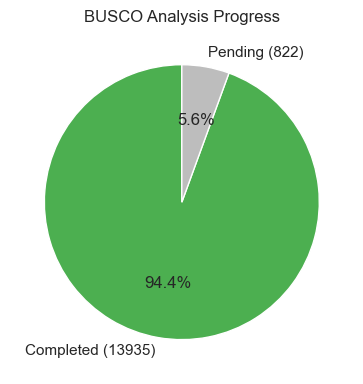

In [4]:
completed = set(df["annotation_id"])
pending = ann[~ann["annotation_id"].isin(completed)]

fig, ax = plt.subplots(figsize=(5, 4))
counts = [len(df), len(pending)]
ax.pie(counts, labels=[f"Completed ({counts[0]})", f"Pending ({counts[1]})"],
       autopct="%1.1f%%", colors=["#4CAF50", "#BDBDBD"], startangle=90)
ax.set_title("BUSCO Analysis Progress")
plt.tight_layout()
plt.show()

## Summary Statistics

In [5]:
metrics = ["complete", "single", "duplicated", "fragmented", "missing"]
df[metrics].describe().round(2)

,complete,single,duplicated,fragmented,missing
count,13935.00,13935.00,13935.00,13935.00,13935.00
mean,90.03,85.17,4.87,4.79,5.19
std,15.61,20.62,14.52,5.75,12.36
min,0.00,0.00,0.00,0.00,0.00
25%,88.40,83.70,0.00,0.80,0.00
50%,96.10,93.00,0.80,3.10,1.60
75%,98.40,96.90,2.30,6.20,4.70
max,100.00,100.00,100.00,51.90,100.00


## Distribution of Completeness Scores

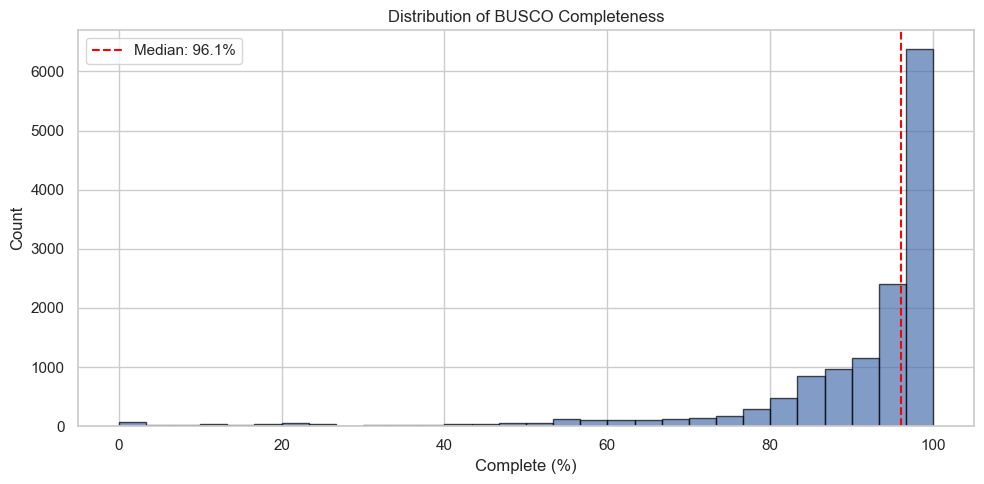

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df["complete"], bins=30, edgecolor="black", alpha=0.7)
ax.set_xlabel("Complete (%)")
ax.set_ylabel("Count")
ax.set_title("Distribution of BUSCO Completeness")
ax.axvline(df["complete"].median(), color="red", linestyle="--", label=f"Median: {df['complete'].median():.1f}%")
ax.legend()
plt.tight_layout()
plt.show()

## Breakdown: Single vs Duplicated vs Fragmented vs Missing

Stacked bar chart for all annotations, sorted by completeness.

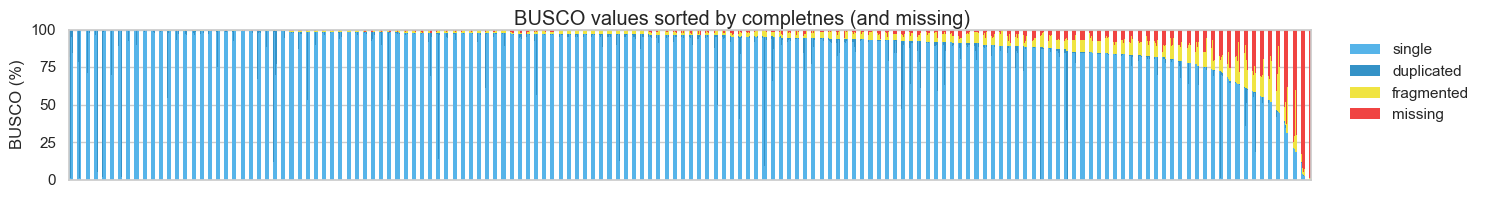

In [7]:
# Sort by completeness (BUSCO complete = single + duplicated, then missing), descending
df_s = df.iloc[::10,].sort_values("missing").sort_values("complete", ascending=False).copy()

# Exclude "complete" from the stacks; plot the components instead
stack_cols = ["single", "duplicated", "fragmented", "missing"]

# Build plotting DF (one bar per annotation_id)
plot_df = (
    df_s.set_index("annotation_id")[stack_cols]
        .astype(float)
)

ax = plot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(15, 2),  
    color=[BUSCO_COLOR_MAP[c] for c in stack_cols],
    edgecolor=None,
    linewidth=0,
)

ax.set_ylabel("BUSCO (%)")
ax.set_xlabel("")
ax.set_ylim(0, 100)

# Do not plot the ids (hide x tick labels and ticks)
ax.set_xticks([])
ax.tick_params(axis="x", length=0)

ax.legend(title="", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

plt.tight_layout()
plt.suptitle("BUSCO values sorted by completnes (and missing)")
plt.show()

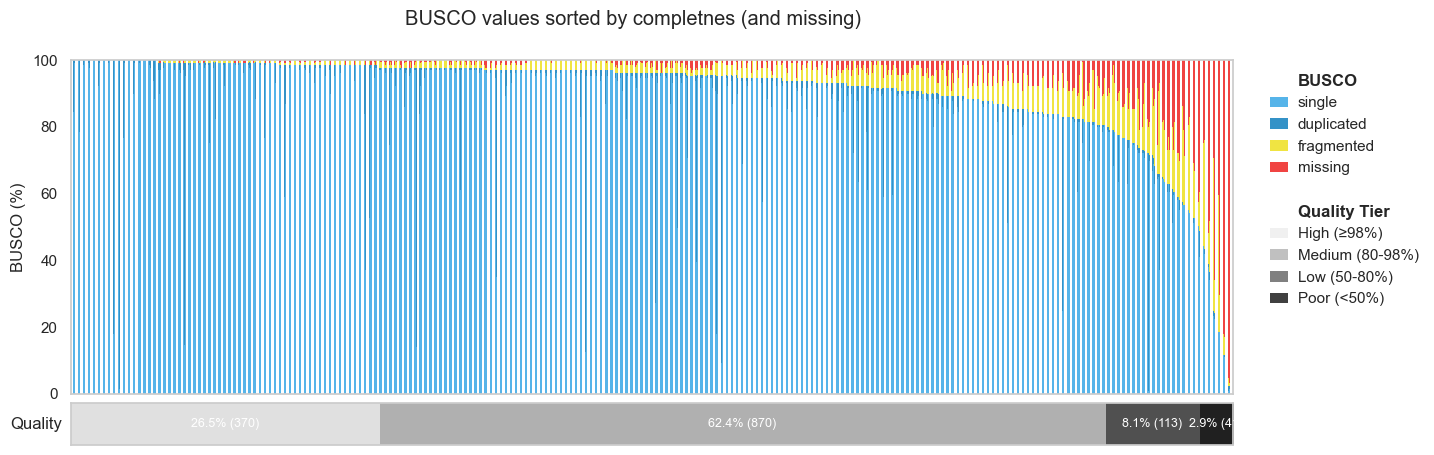

In [8]:
df_s = df.iloc[::10].sort_values("missing").sort_values("complete", ascending=False).copy()
# df_s = df.sort_values("missing").sort_values("complete", ascending=False).copy()

plot_df = df_s.set_index("annotation_id")[stack_cols].astype(float)

tier_to_int = {t: i for i, t in enumerate(TIER_ORDER)}
q = df_s["quality"].map(tier_to_int).to_numpy()
heat = q.reshape(1, -1)

# % per tier (in the plotted subset/order)
cmap = ListedColormap(TIER_PALETTE)
tier_counts = df_s["quality"].value_counts().reindex(TIER_ORDER, fill_value=0)
tier_perc = (tier_counts / tier_counts.sum() * 100).round(1)

# --- Layout ---
fig, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True,
    figsize=(15, 5),
    gridspec_kw={"height_ratios": [8, 1], "hspace": 0.05},
)

# --- 1) BUSCO stacked bars ---
plot_df.plot(
    kind="bar",
    stacked=True,
    ax=ax1,
    color=[BUSCO_COLOR_MAP[c] for c in stack_cols],
    edgecolor="none",
    linewidth=0,
)
ax1.set_ylabel("BUSCO (%)")
ax1.set_ylim(0, 100)
ax1.set_xticks([])
ax1.grid(False)  

# --- 2) Quality tier heatmap strip ---
# Force consistent mapping: 0..K-1 always maps to the same colors in TIER_PALETTE
ax2.imshow(
    heat,
    aspect="auto",
    cmap=cmap,
    interpolation="nearest",
    vmin=-0.5,
    vmax=len(TIER_ORDER) - 0.5,
)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_ylabel("Quality", rotation=0, labelpad=25, va="center")

n = len(q)
start = 0
for tier in TIER_ORDER:
    cnt = int(tier_counts[tier])
    if cnt == 0:
        continue
    end = start + cnt
    center = (start + end - 1) / 2.0

    # Text inside the strip if the block is wide enough, else put it above
    label = f"{tier_perc[tier]}% ({tier_counts[tier]})"
    if cnt >= max(3, int(0.03 * n)):  # heuristic: enough room
        ax2.text(center, 0, label, ha="center", va="center", fontsize=9, color = 'White')
    else:
        ax2.text(center, -0.55, label, ha="center", va="bottom", fontsize=9, clip_on=False)

    start = end

# --- Single combined legend (with section titles) ---
leg = ax1.get_legend()
if leg is not None:
    leg.remove()

busco_handles = [Patch(facecolor=BUSCO_COLOR_MAP[c], edgecolor="none") for c in stack_cols]
tier_handles  = [Patch(facecolor=TIER_COLOR_MAP[t],  edgecolor="none") for t in TIER_ORDER]

# Dummy (invisible) handles to act as "section headers" inside one legend
hdr_busco = Patch(facecolor="none", edgecolor="none", label="BUSCO")
hdr_tier  = Patch(facecolor="none", edgecolor="none", label="Quality Tier")
hdr_empy  = Patch(facecolor="none", edgecolor="none", label="")

handles = [hdr_busco] + busco_handles +  [hdr_empy] + [hdr_tier] + tier_handles
labels  = ["BUSCO"] + stack_cols + [""] + ["Quality Tier"] + TIER_ORDER

ax1.legend(
    handles=handles,
    labels=labels,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False,
    handlelength=1.2,
    handletextpad=0.6,
)

leg = ax1.get_legend()
# Make the two section headers bold (they are the 1st and (len(stack_cols)+2)th labels)
header_idxs = [0, len(stack_cols) + 1]  # "BUSCO", "Quality Tier"

for i in [0, len(busco_handles)+2]:
    leg.get_texts()[i].set_fontproperties(FontProperties(weight="bold"))

# Optional: hide the (empty) handle boxes for the header rows
for i in header_idxs:
    leg.legend_handles[i].set_visible(False)

plt.suptitle("BUSCO values sorted by completnes (and missing)")
plt.show()

## Box Plots of All Metrics

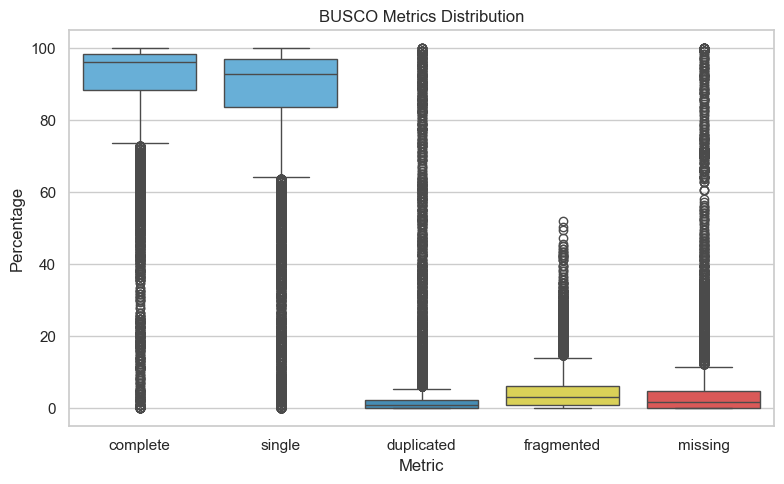

In [9]:
melted = df[metrics].melt(var_name="Metric", value_name="Percentage")

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=melted, x="Metric", y="Percentage", hue="Metric", ax=ax, palette=BUSCO_COLORS, legend=False)
ax.set_title("BUSCO Metrics Distribution")
plt.tight_layout()
plt.show()

## Duplication vs Fragmentation

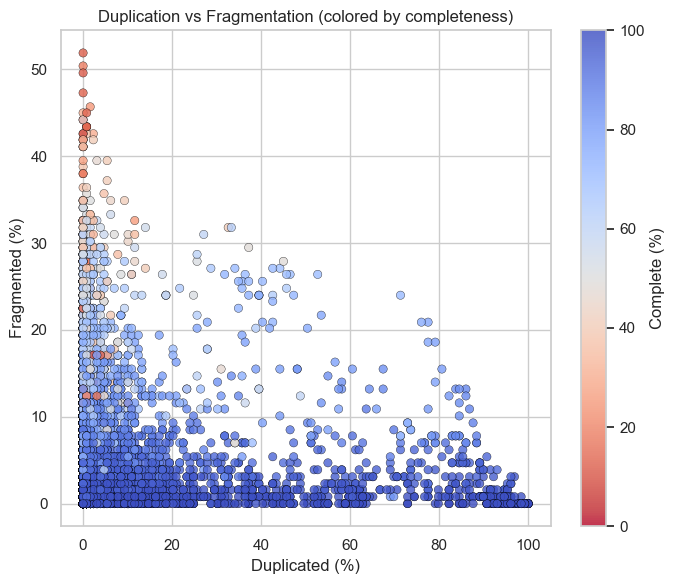

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))
scatter = ax.scatter(df["duplicated"], df["fragmented"], c=df["complete"], cmap="coolwarm_r", edgecolors="black", linewidth=0.3, alpha=0.8)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Complete (%)")
ax.set_xlabel("Duplicated (%)")
ax.set_ylabel("Fragmented (%)")
ax.set_title("Duplication vs Fragmentation (colored by completeness)")
plt.tight_layout()
plt.show()

## Quality Tiers

Categorise annotations by completeness thresholds.

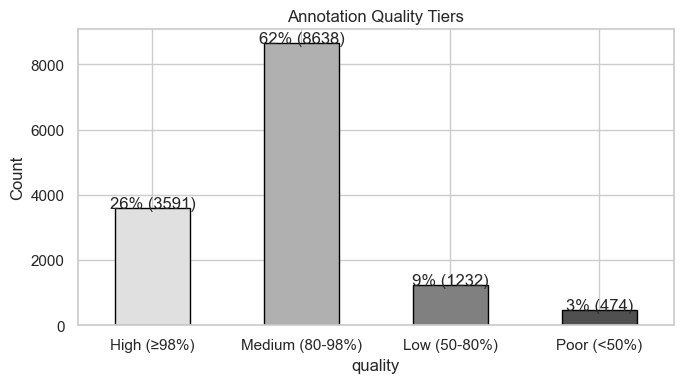

In [11]:
tier_counts = df["quality"].value_counts().reindex(TIER_ORDER, fill_value=0)

fig, ax = plt.subplots(figsize=(7, 4))
tier_counts.plot.bar(ax=ax, color=TIER_PALETTE, edgecolor="black")
ax.set_ylabel("Count")
ax.set_title("Annotation Quality Tiers")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

for i, v in enumerate(tier_counts):
    p = v * 100 / tier_counts.sum()
    ax.text(i, v + 0.5, f"{round(p)}% ({v})", ha="center")

plt.tight_layout()
plt.show()

## Outliers

Annotations with the lowest completeness scores.

In [12]:
complete_zero = len(df[df["complete"] == 0.0])
complete_five = len(df[df["complete"] < 5.0])
tot = len(df)
print (f"Annotation with 0% completness = {complete_zero} / {tot}")
print (f"Annotation with <5% completness = {complete_five} / {tot}")

Annotation with 0% completness = 26 / 13935
Annotation with <5% completness = 85 / 13935


In [13]:
df.nsmallest(10, "complete")[["species_label", "assembly_accession"] + metrics + ["annotation_id"]]

,species_label,assembly_accession,complete,single,duplicated,fragmented,missing,annotation_id
761,NaN,GCA_025024175.1,0.0,0.0,0.0,0.8,99.2,26a064e2c565054512e9339921eaf93e
1288,NaN,GCA_904066235.2,0.0,0.0,0.0,0.0,100.0,9f655de30fe0c2d7e110b1fcfe9f7381
1551,NaN,GCA_902810595.1,0.0,0.0,0.0,0.0,100.0,c542abca15366d5e271c0a8ad7fe577f
2359,NaN,GCA_001600855.1,0.0,0.0,0.0,0.0,100.0,80b6c111052f1ad16057946d08af60c6
2372,NaN,GCA_904067135.1,0.0,0.0,0.0,0.0,100.0,b99a88141a88b2917392db7c82ab22c9
2957,NaN,GCA_014319735.1,0.0,0.0,0.0,2.3,97.7,47005098974cbb3a60d3848dcfddceed
3160,NaN,GCA_001412515.3,0.0,0.0,0.0,0.8,99.2,30011fb070d9b42b60cab4b3ce6cd19b
3365,NaN,GCA_904066225.2,0.0,0.0,0.0,0.0,100.0,19b0c9e9be5eedbff760784f23a6250d
4467,NaN,GCA_964200485.2,0.0,0.0,0.0,3.1,96.9,a9087feeccb0405e379d17d79058fb91
4564,NaN,GCA_051942585.1,0.0,0.0,0.0,0.0,100.0,78af3bdfc53c06f4a919f657d4a41a8f
